In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from methods2 import *
def logit(x, c=True, eps=1e-5):
    if c: c = np.min(x)
    else: c=0
    x2 = (x-c)/(1-c)
    return np.log((x2+eps)/(1-x2+eps)), c

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def kernel(t):
    c = .75
    return np.clip(c*(1-t**2),a_min=0,a_max=c)
    
num_fam = 10
start = 0

#https://www.sciencedirect.com/science/article/pii/S0047259X01920123?ref=pdf_download&fr=RR-2&rr=8b8fb5f4cbd4a934

In [34]:
scenarios = ['IFEval','BBH','MATH Lvl 5','GPQA','MUSR','MMLU-PRO','MMLU','ARC','HellaSwag','Winogrande','TruthfulQA','GSM8K']

In [35]:
scenario = 'ARC'
data = pd.read_csv('data/data_v1.csv')
print(data.shape)
data['logS'] = np.log(data['#Params (B)'])
data['logT'] = np.log(data['Pretraining Data Size (T)'])
data['logS*logT'] = data['logS']*data['logT']
data['logF'] = np.log(data['FLOPs (1E21)'])
data = data.loc[~data.Instruct,['Model','Family','Instruct','logS','logT','logF','logS*logT']+[scenario]]
data = data.dropna()
data = data.sort_values(by=['Family','logS'])
data = data.rename(columns={'Model':'model', 'Family':'family', 'Instruct':'instruct'})
Fam = np.array(data.family)
print(data.shape)

(198, 118)
(113, 8)


Isotonic regression

In [53]:
families,counts = np.unique(Fam,return_counts=True)
families = families[counts>1]
families

array(['bloom', 'codegen', 'codellama', 'deepseek-coder', 'falcon',
       'gemma', 'gpt-neo/j', 'internlm2', 'llama', 'llama-2',
       'meta-llama-3', 'mpt', 'olmo', 'openllama', 'openllamav2', 'opt',
       'phi', 'pythia', 'pythia-deduped', 'qwen', 'qwen1.5', 'qwen2',
       'redpajama-incite-base', 'rwkv', 'stablelm', 'starcoder',
       'starcoder2', 'xglm', 'yi', 'yi-1.5', 'yi-200k'], dtype=object)

In [54]:
families = ['bloom', 'codegen', 'codellama', 'deepseek-coder', 'falcon',
       'gemma', 'gpt-neo/j', 'internlm2', 'llama', 'llama-2','mpt', 'olmo', 'openllama', 'openllamav2', 'opt',
       'phi', 'pythia', 'pythia-deduped', 'qwen', 'qwen1.5', 'qwen2',
       'redpajama-incite-base', 'rwkv', 'stablelm', 'starcoder',
       'starcoder2', 'xglm', 'yi', 'yi-1.5', 'yi-200k']

In [55]:
from scipy.optimize import minimize

def generate_constraints(A):
        def constraint(z, row):
            return np.dot(row, z)
        
        constraints = []
        for row in A:
            constraints.append({
                'type': 'ineq',
                'fun': lambda z, row=row: constraint(z, row)
            })
        return constraints

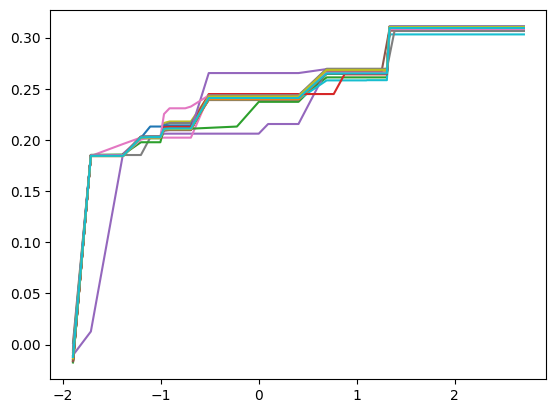

In [56]:
errors = []
for test_family in families:
    X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
    logT_train = X_train[:,:1].cpu().numpy()
    logT_test = X_test[:,:1].cpu().numpy()
    logS_train = X_train[:,1:2].cpu().numpy() 
    logS_test = X_test[:,1:2].cpu().numpy() 
    Y_train, c = logit(Y_train.cpu().numpy(),c=False)
    Y_test = Y_test.cpu().numpy()
    D_train = D_train.cpu().numpy()
    D_test = D_test.cpu().numpy()
    
    DT_train = np.array(pd.get_dummies(logT_train.squeeze()))
    sort_ind = np.argsort(logT_train.squeeze())
    rec_ind = np.argsort(sort_ind)
    g = np.sort(np.abs(np.random.normal(0,.1,DT_train.shape[1])))
    DT_train.shape

    def get_slope_intercept(g):
        slope = (DT_train[sort_ind]@g[:,None])[rec_ind]
        intercept = (np.linalg.inv(D_train.T@D_train)@D_train.T@(Y_train-slope*logS_train))
        return intercept,slope
        
    def loss(g):
        intercept,slope = get_slope_intercept(g)
        return ((Y_train-slope*logS_train-D_train@intercept)**2).mean()

    A = -np.eye(g.shape[0])
    A = A[:-1,:]
    for i in range(g.shape[0]-1):
        A[i,i+1] = 1
    cons = generate_constraints(A)
    solution = minimize(loss, g, constraints=cons)
    g = solution.x

    slope = np.interp(logT_test, np.unique(logT_train), g)
    intercept,_ = get_slope_intercept(g)
    intercept = intercept[0]

    plt.plot(np.unique(logT_train),g)
    errors.append(np.abs(sigmoid(slope*logS_test + intercept)-Y_test).mean())

In [57]:
np.mean(errors)

0.09048540698475536

In [40]:
errors

[0.031205780451623727,
 0.05213726013397352,
 0.028649684731939518,
 0.05872502113133529,
 0.10814060162725009,
 0.18612969209622188,
 0.022883548445976593,
 0.15601465343997628,
 0.12340788012050441,
 0.12648393561770624,
 0.13952730021432747,
 0.07886526776784714,
 0.051194664919986255,
 0.08958877678258922,
 0.0430846871917141,
 0.08970847275925165,
 0.27041340149839255,
 0.0048016601792905955,
 0.022328068874297054,
 0.11188581298139905,
 0.09864306375658521,
 0.12739299686347116,
 0.0694826641693796,
 0.0265101642615856,
 0.0670539504058822,
 0.11740735715256186,
 0.021998310627771023,
 0.051984731465347454,
 0.15829745971120263,
 0.1712370175986735,
 0.14966699321843557]

In [41]:
errors = []
for test_family in tqdm(families):
    X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
    logT_train = X_train[:,:1].cpu().numpy()
    logT_test = X_test[:,:1].cpu().numpy()
    logS_train = X_train[:,1:2].cpu().numpy() 
    logS_test = X_test[:,1:2].cpu().numpy() 
    Y_train, c = logit(Y_train.cpu().numpy(),c=False)
    Y_test = Y_test.cpu().numpy()
    D_train = D_train.cpu().numpy()
    D_test = D_test.cpu().numpy()
    
    DT_train = np.array(pd.get_dummies(logT_train.squeeze()))
    sort_ind = np.argsort(logT_train.squeeze())
    rec_ind = np.argsort(sort_ind)
    g = np.sort(np.abs(np.random.normal(0,.1,DT_train.shape[1])))
    DT_train.shape

    for b in range(10):
        slope = (DT_train[sort_ind]@g[:,None])[rec_ind]
        intercept = (np.linalg.inv(D_train.T@D_train)@D_train.T@(Y_train-slope*logS_train))
    
        def get_slope_intercept(g):
            slope = (DT_train[sort_ind]@g[:,None])[rec_ind]
            intercept = (np.linalg.inv(D_train.T@D_train)@D_train.T@(Y_train-slope*logS_train))
            return intercept,slope
            
        def loss(g):
            slope = (DT_train[sort_ind]@g[:,None])[rec_ind]
            return ((Y_train-slope*logS_train-D_train@intercept)**2).mean()
    
        A = -np.eye(g.shape[0])
        A = A[:-1,:]
        for i in range(g.shape[0]-1):
            A[i,i+1] = 1
        cons = generate_constraints(A)
        solution = minimize(loss, g, constraints=cons)
        g = solution.x

    slope = (DT_train[sort_ind]@g[:,None])[rec_ind]
    intercept = (np.linalg.inv(D_train.T@D_train)@D_train.T@(Y_train-slope*logS_train))
    intercept = intercept[0]
    
    slope = np.interp(logT_test, np.unique(logT_train), g)

    errors.append(np.abs(sigmoid(slope*logS_test + intercept)-Y_test).mean())

  0%|          | 0/31 [00:00<?, ?it/s]

In [42]:
intercept

array([-0.9029467])

In [43]:
np.interp(logT_test, np.unique(logT_train), g)

array([[0.24803783]])

In [44]:
np.mean(errors)

0.09337267326706049

poly interaction

In [45]:
from sklearn.preprocessing import PolynomialFeatures

In [46]:
families,counts = np.unique(Fam,return_counts=True)
families = families[counts>1]

In [63]:
for degree in [0,1,2,3,4,5]:
    errors = []
    for test_family in families:
    
        X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
        logT_train = X_train[:,:1].cpu().numpy()
        logT_test = X_test[:,:1].cpu().numpy()
        logS_train = X_train[:,1:2].cpu().numpy() 
        logS_test = X_test[:,1:2].cpu().numpy() 
        Y_train, c = logit(Y_train.cpu().numpy(),c=False)
        Y_test = Y_test.cpu().numpy()
        D_train = D_train.cpu().numpy()
        D_test = D_test.cpu().numpy()
        
        Z_train = np.hstack((logS_train*PolynomialFeatures(degree).fit_transform(logT_train),D_train))
        Z_test = np.hstack((logS_test*PolynomialFeatures(degree).fit_transform(logT_test),D_test))
        beta = np.linalg.inv(Z_train.T@Z_train)@Z_train.T@Y_train
        Y_hat = c+(1-c)*sigmoid(Z_test@beta)
        error = np.abs((Y_hat-Y_test)).mean()
        errors.append(error)
        #print(test_family,error)
    print(degree,np.mean(errors))

0 0.03152276180622777
1 0.02304536793430105
2 0.02369392287840485
3 0.024424571300037543
4 0.026074987948821998
5 0.023728358903663517


In [62]:
for degree in [0,1,2,3,4,5]:
    errors = []
    for test_family in families:
    
        X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
        logT_train = X_train[:,:1].cpu().numpy()
        logT_test = X_test[:,:1].cpu().numpy()
        logS_train = X_train[:,1:2].cpu().numpy() 
        logS_test = X_test[:,1:2].cpu().numpy() 
        Y_train, c = logit(Y_train.cpu().numpy(),c=False)
        Y_test = Y_test.cpu().numpy()
        D_train = D_train.cpu().numpy()
        D_test = D_test.cpu().numpy()

        poly = PolynomialFeatures(degree).fit_transform(logT_train)
        Z_train = np.hstack((logS_train*poly,poly[:,1:],D_train))
        poly = PolynomialFeatures(degree).fit_transform(logT_test)
        Z_test = np.hstack((logS_test*PolynomialFeatures(degree).fit_transform(logT_test),poly[:,1:],D_test))
        beta = np.linalg.inv(Z_train.T@Z_train)@Z_train.T@Y_train
        Y_hat = c+(1-c)*sigmoid(Z_test@beta)
        error = np.abs((Y_hat-Y_test)).mean()
        errors.append(error)
        #print(test_family,error)
    print(degree,np.mean(errors))

0 0.03152276180622777
1 0.02370066521218172
2 0.025852190933626826
3 0.03577224252500367
4 0.04697016464196369
5 0.04860848567424836


plt.plot(logT_train,(beta.squeeze()[:degree+1]*PolynomialFeatures(degree).fit_transform(logT_train)).sum(1),'bo')

In [48]:
from sklearn.preprocessing import SplineTransformer
degree=1

In [51]:
for degree in [0,1,2,3,4,5]:
    for knot in [2,3,4,5,6]:
        errors = []
        for test_family in families:
        
            X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
            logT_train = X_train[:,:1].cpu().numpy()
            logT_test = X_test[:,:1].cpu().numpy()
            logS_train = X_train[:,1:2].cpu().numpy() 
            logS_test = X_test[:,1:2].cpu().numpy() 
            Y_train, c = logit(Y_train.cpu().numpy(),c=False)
            Y_test = Y_test.cpu().numpy()
            D_train = D_train.cpu().numpy()
            D_test = D_test.cpu().numpy()
    
            spline = SplineTransformer(degree=degree, n_knots=knot).fit(logT_train)
            Z_train = np.hstack((logS_train*spline.transform(logT_train),D_train))
            Z_test = np.hstack((logS_test*spline.transform(logT_test),D_test))

            from sklearn.linear_model import LinearRegression
            reg = LinearRegression(fit_intercept=False, positive=False).fit(Z_train, Y_train.squeeze())
            beta = reg.coef_[:,None]
            
            #beta = np.linalg.inv(Z_train.T@Z_train)@Z_train.T@Y_train
            Y_hat = c+(1-c)*sigmoid(Z_test@beta)
            error = np.abs((Y_hat-Y_test)).mean()
            errors.append(error)
            #print(test_family,error)
        print(degree,knot,np.mean(errors))

0 2 0.031342134598351
0 3 0.026936945101169237
0 4 0.025672238287388658
0 5 0.0280289781296261
0 6 0.027705359676918256
1 2 0.024484633822923582
1 3 0.02522351117315768
1 4 0.02649307750154418
1 5 0.026647697917241746
1 6 0.02546472821950312
2 2 0.025275133745854373
2 3 0.02649816226242775
2 4 0.027517348987861928
2 5 0.025622656178897956
2 6 0.030189702706069875
3 2 0.026663705579654026
3 3 0.02856072822663176
3 4 0.02559125784637044
3 5 0.030687592522691546
3 6 0.03720415164680648
4 2 0.02906204955036153
4 3 0.02552348929474277
4 4 0.02992749155187753
4 5 0.036958800297276814
4 6 0.04213055037294847
5 2 0.025972559367839633
5 3 0.028798883661008537
5 4 0.036374345699816714
5 5 0.041704019263057175
5 6 0.04343190126486055


In [61]:
for degree in [0,1,2,3,4,5]:
    for knot in [2,3,4,5,6]:
        errors = []
        for test_family in families:
        
            X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
            logT_train = X_train[:,:1].cpu().numpy()
            logT_test = X_test[:,:1].cpu().numpy()
            logS_train = X_train[:,1:2].cpu().numpy() 
            logS_test = X_test[:,1:2].cpu().numpy() 
            Y_train, c = logit(Y_train.cpu().numpy(),c=False)
            Y_test = Y_test.cpu().numpy()
            D_train = D_train.cpu().numpy()
            D_test = D_test.cpu().numpy()
    
            spline = SplineTransformer(degree=degree, n_knots=knot).fit(logT_train)
            Z_train = np.hstack((logS_train*spline.transform(logT_train),spline.transform(logT_train),D_train))
            Z_test = np.hstack((logS_test*spline.transform(logT_test),spline.transform(logT_test),D_test))

            from sklearn.linear_model import LinearRegression
            reg = LinearRegression(fit_intercept=False, positive=False).fit(Z_train, Y_train.squeeze())
            beta = reg.coef_[:,None]
            
            #beta = np.linalg.inv(Z_train.T@Z_train)@Z_train.T@Y_train
            Y_hat = c+(1-c)*sigmoid(Z_test@beta)
            error = np.abs((Y_hat-Y_test)).mean()
            errors.append(error)
            #print(test_family,error)
        print(degree,knot,np.mean(errors))

0 2 0.03152276180622781
0 3 0.02730268663197894
0 4 0.027294805042582936
0 5 0.027221657707085463
0 6 0.03106252182474865
1 2 0.023709709789250785
1 3 0.02888805623394201
1 4 0.028757956543562512
1 5 0.03746276401842256
1 6 0.029568436867522016
2 2 0.025852190933626413
2 3 0.03214087093756419
2 4 0.04121065643719608
2 5 0.03470100109085554
2 6 0.048268556358377075
3 2 0.035772242525002475
3 3 0.043612479710485305
3 4 0.03638550048557009
3 5 0.04921245175209995
3 6 0.06314953299896467
4 2 0.04697016464196146
4 3 0.039757155975027623
4 4 0.06135607755306568
4 5 0.06564881184842294
4 6 0.06669560266736196
5 2 0.04860848567467862
5 3 0.06114759796910669
5 4 0.07017303114787102


/tmp/ipykernel_1277758/1696390712.py:14: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


5 5 0.06487908708998655
5 6 0.07953493995025974


In [50]:
errors = []
for test_family in families:

    X_train, F_train, D_train, Y_train, X_test, F_test, D_test, Y_test = pred_data2(data, test_family, [scenario])
    Y_train, c = logit(Y_train.cpu().numpy(),c=True)
    Y_test = Y_test.cpu().numpy()
    D_train = D_train.cpu().numpy()
    D_test = D_test.cpu().numpy()
    
    Z_train = np.hstack((F_train.cpu().numpy(),D_train))
    Z_test = np.hstack((F_test.cpu().numpy(),D_test))
    beta = np.linalg.inv(Z_train.T@Z_train)@Z_train.T@Y_train
    Y_hat = c+(1-c)*sigmoid(Z_test@beta)
    error = np.abs((Y_hat-Y_test)).mean()
    errors.append(error)
    #print(test_family,error)
print(np.mean(errors))

0.06243894453002844


local reg

In [1069]:
h = .5

In [1070]:
X = logS_train
U = logT_train
Y = Y_train
D = D_train

In [1071]:
def fit_local_reg(X,U,Y,D,u,h):
    S = []
    for xi,ui in zip(X,U):
        Uu = np.diag((U - ui).squeeze())
        Gu = np.hstack((X,Uu@X))
        Wh = np.diag(kernel((U - ui).squeeze()/h)/h)
        S.append(xi*(np.linalg.inv(Gu.T@Wh@Gu)@Gu.T@Wh)[0])
    S = np.vstack(S)
    I = np.eye(S.shape[0])
    P = (I-S)
    A = P@D
    intercepts = (np.linalg.inv(A.T@A)@A.T@P@Y)
    Y_tilde = Y - D@intercepts
    
    Uu = np.diag((U - u).squeeze())
    Gu = np.hstack((X,Uu@X))
    Wh = np.diag(kernel((U - u).squeeze()/h)/h)
    slope = (np.linalg.inv(Gu.T@Wh@Gu)@Gu.T@Wh@Y_tilde)[0][0]
    
    return intercepts.squeeze()[0], max(slope,0)

In [1072]:
Y_hat = []
for u,x in zip(logT_test,logS_test):
    a,b = fit_local_reg(X,U,Y,D,u,h)
    Y_hat.append(c+(1-c)*sigmoid(a+b*x))
Y_hat = np.vstack(Y_hat)

In [1078]:
sigmoid(a+b*x)

array([0.52428024])

In [1074]:
a,b

(-0.8257284292862774, 0.26630010130160375)

In [1075]:
Y_hat

array([[0.33523692],
       [0.37921979],
       [0.42371718],
       [0.46930186],
       [0.52428024]])

In [1076]:
np.abs(Y_test-Y_hat).mean()

0.033648804619559304

In [1077]:
Y_hat,Y_test

(array([[0.33523692],
        [0.37921979],
        [0.42371718],
        [0.46930186],
        [0.52428024]]),
 array([[0.35],
        [0.41],
        [0.46],
        [0.51],
        [0.57]]))

In [ ]:
y = logit(np.array(data[scenario]))
logS = np.array(data['logS'])
logT = np.array(data['logT'])
logF = np.array(data['logF'])


In [29]:
y.shape

(113,)

In [32]:

n_fam = np.sum(ind_fam)

In [24]:
n_models_fam

4

In [33]:
logS[ind_fam]

array([-0.69314718,  0.40546511,  1.94591015,  4.27666612])

(198, 118)
(37, 7)


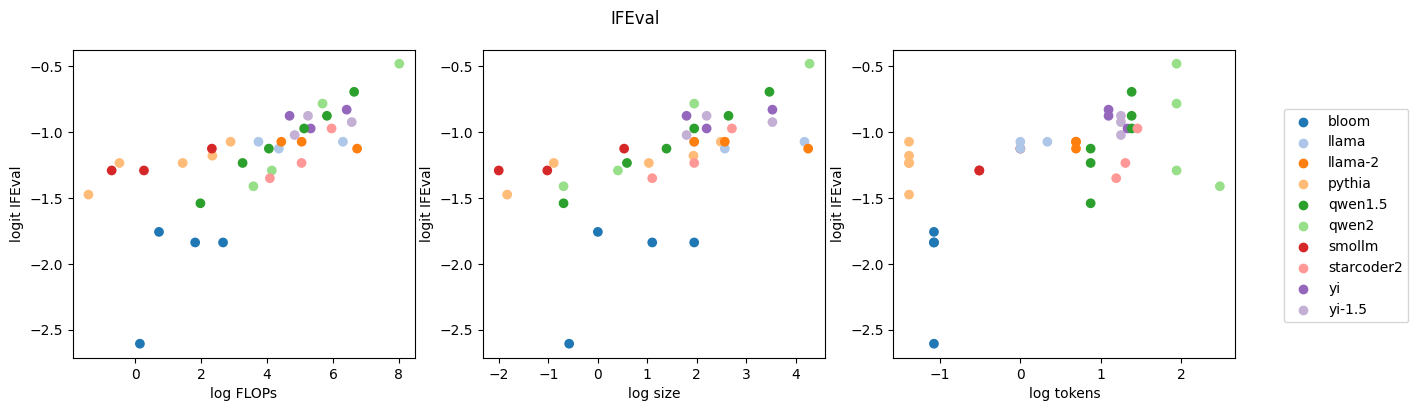

(198, 118)
(37, 7)


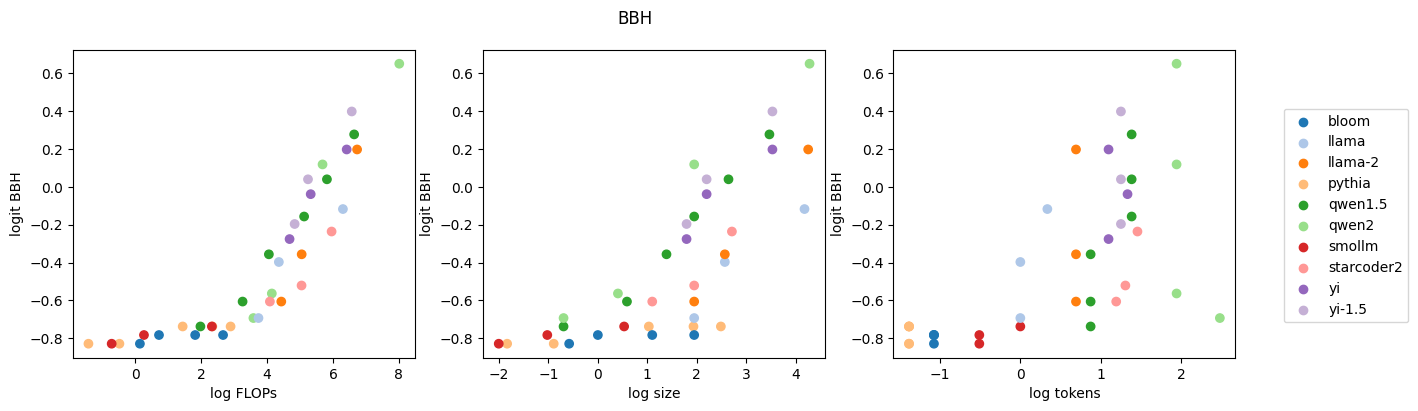

(198, 118)
(37, 7)


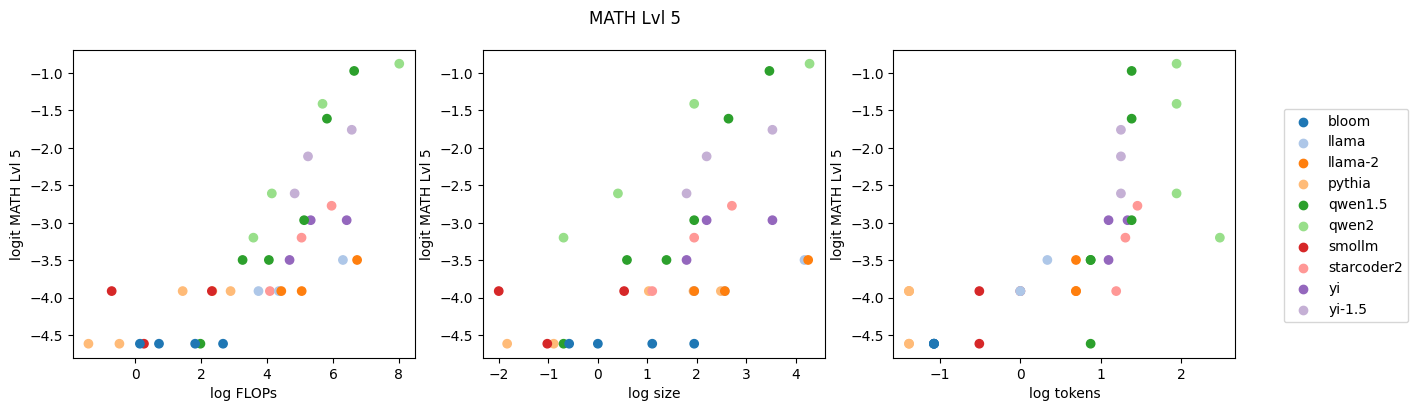

(198, 118)
(37, 7)


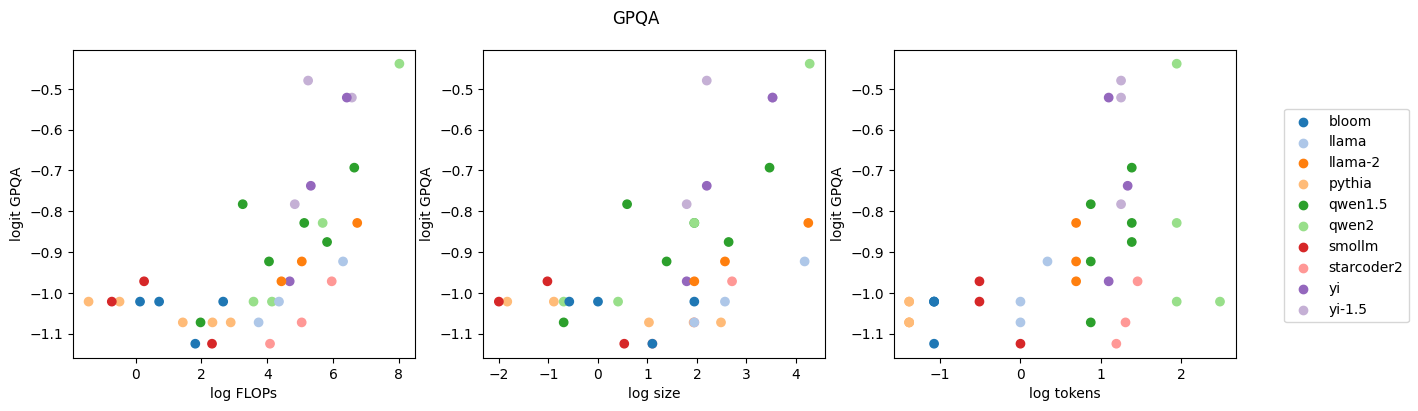

(198, 118)
(37, 7)


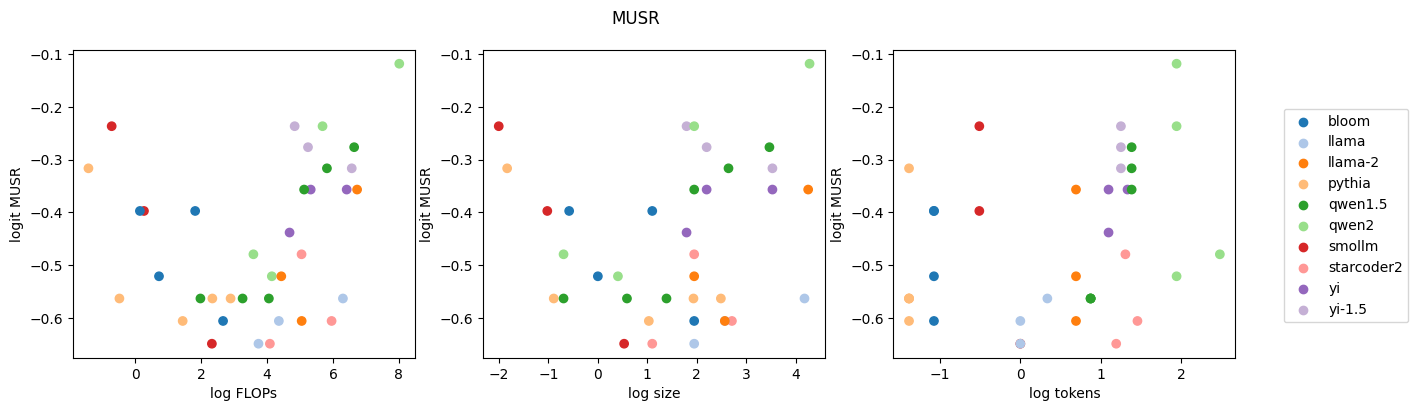

(198, 118)
(37, 7)


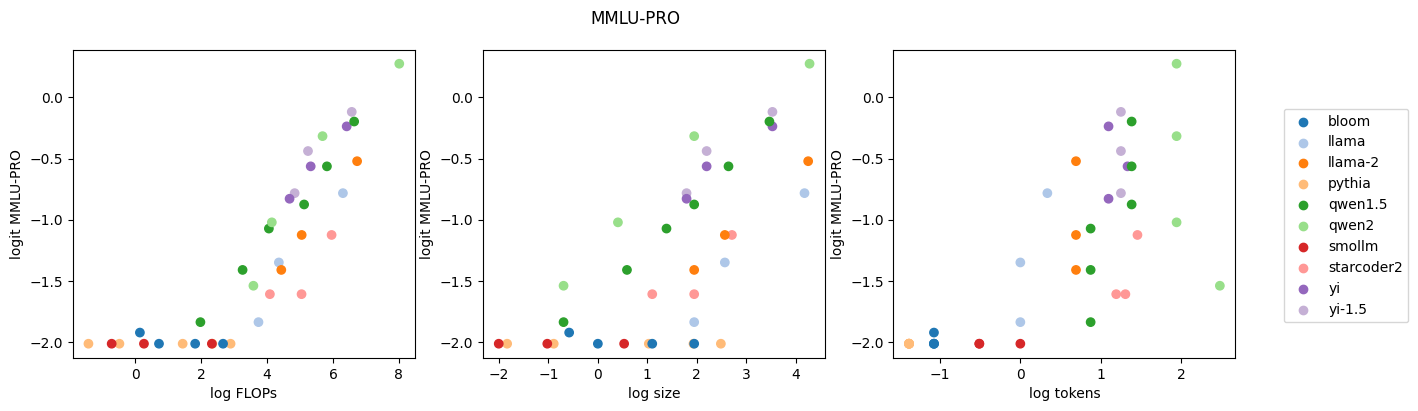

(198, 118)
(56, 7)


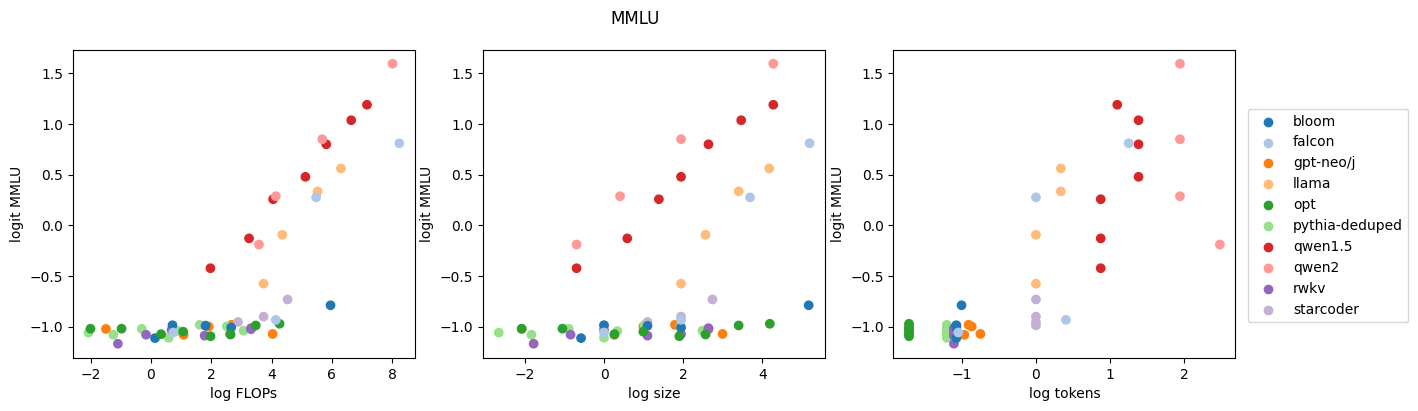

(198, 118)
(56, 7)


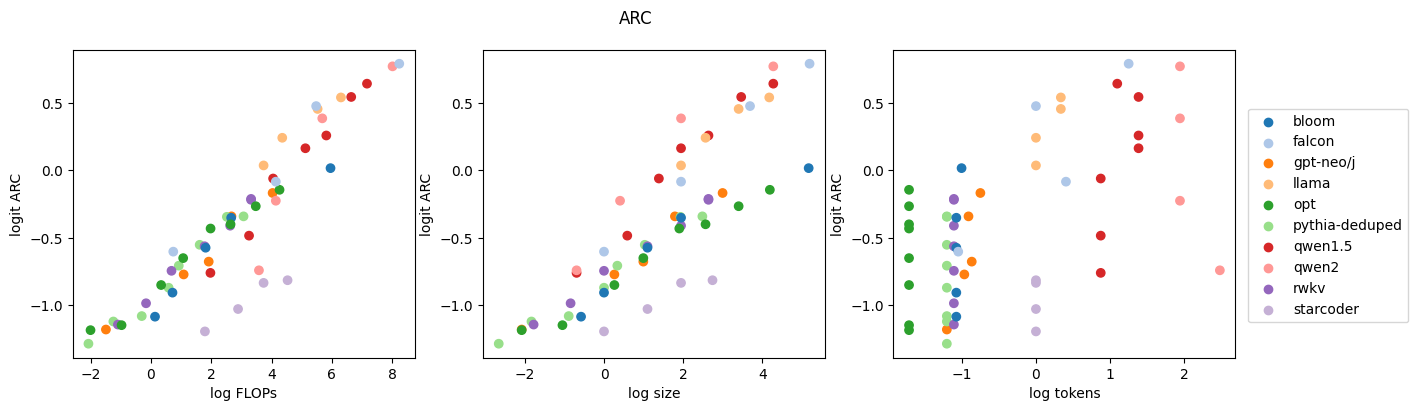

(198, 118)
(56, 7)


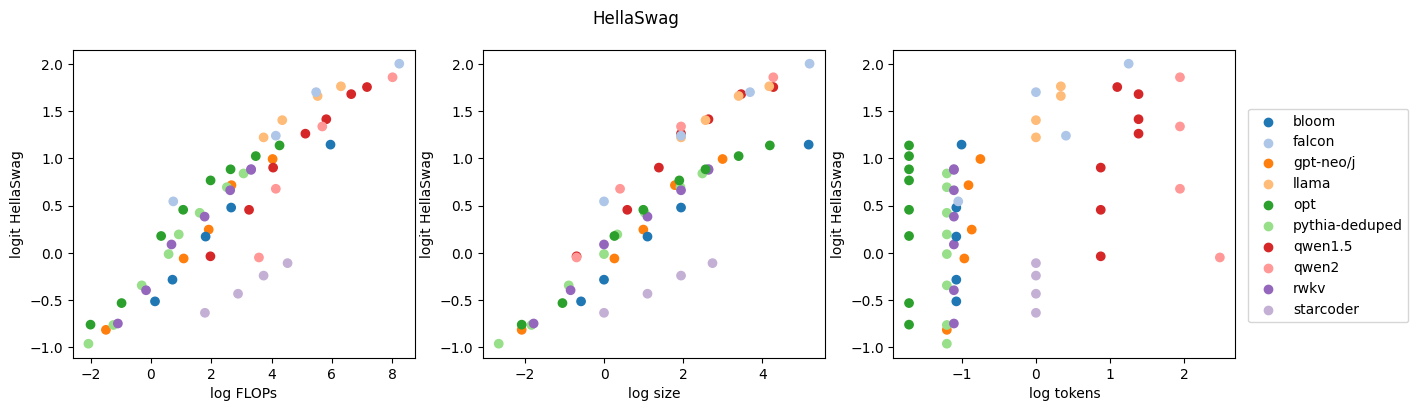

(198, 118)
(56, 7)


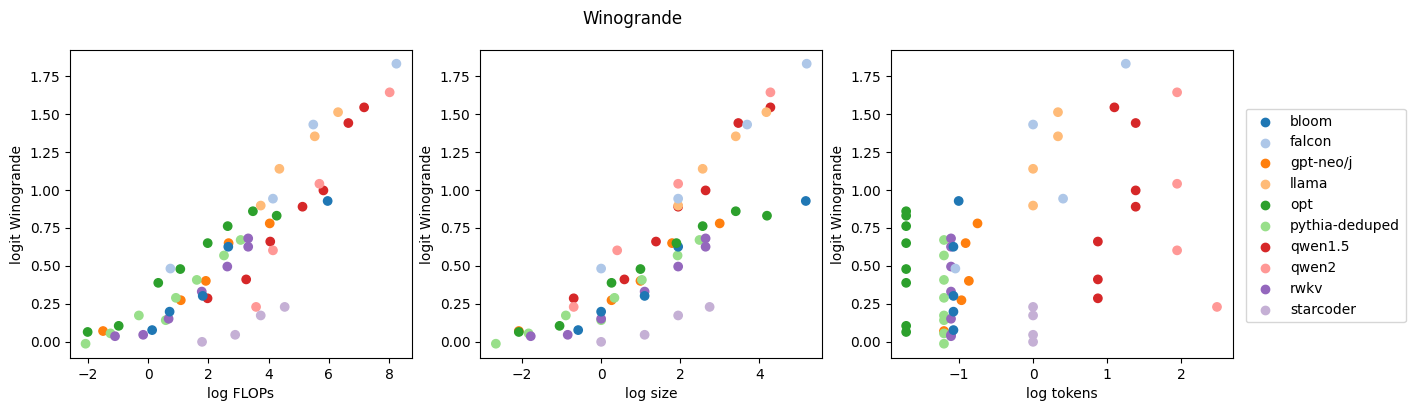

(198, 118)
(56, 7)


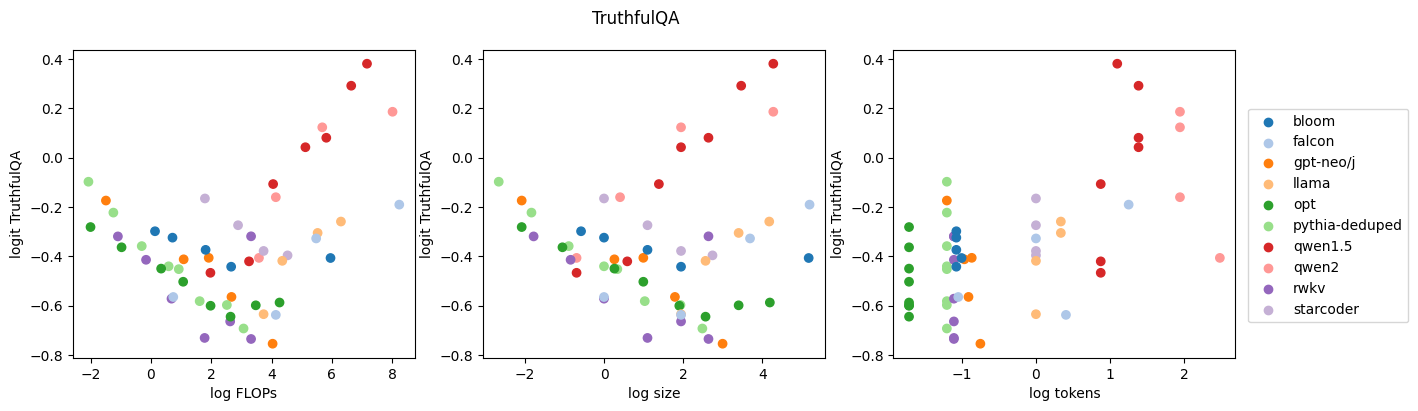

(198, 118)
(56, 7)


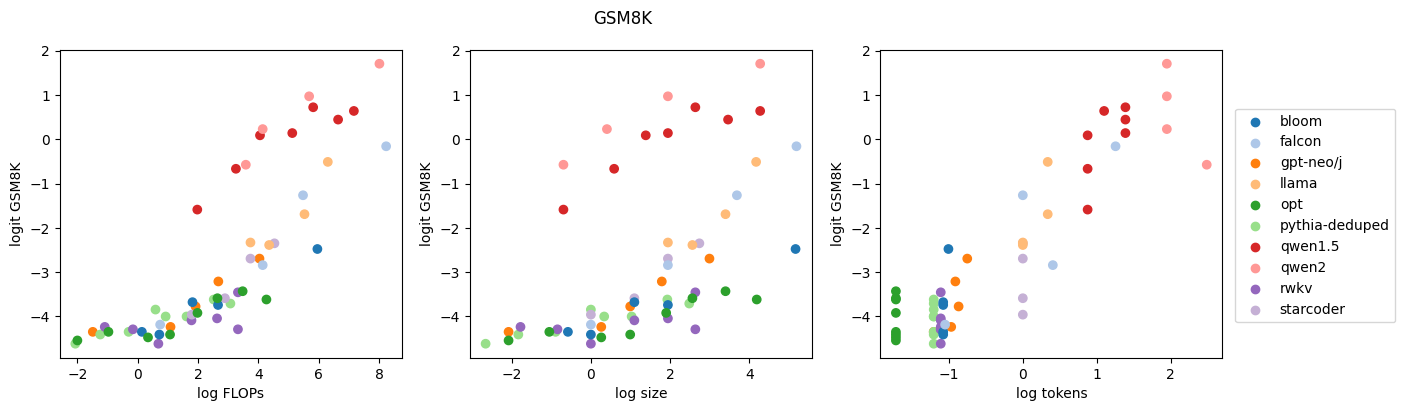

In [409]:
for scenario in scenarios:
    data = pd.read_csv('data/data_v1.csv')
    print(data.shape)
    data['logS'] = np.log(data['#Params (B)'])
    data['logT'] = np.log(data['Pretraining Data Size (T)'])
    data['logF'] = np.log(data['FLOPs (1E21)'])
    data = data.loc[~data.Instruct,['Model','Family','Instruct','logS','logT','logF']+[scenario]]
    data = data.dropna()
    selected_families = list(data.Family.value_counts().iloc[start:start+num_fam].index)
    data = data.loc[[m in selected_families for m in data.Family]]
    print(data.shape)
    
    y = logit(np.array(data[scenario]))
    logS = np.array(data['logS'])
    logT = np.array(data['logT'])
    logF = np.array(data['logF'])
    Fam = np.array(data.Family)
    unique_categories = np.unique(Fam)
    color_map = {category: color for category, color in zip(unique_categories, plt.cm.tab20.colors)}
    colors = [color_map[category] for category in Fam]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    sc1 = axs[0].scatter(logF, y, c=colors)
    axs[0].set_xlabel('log FLOPs')
    axs[0].set_ylabel(f'logit {scenario}')
    sc2 = axs[1].scatter(logS, y, c=colors)
    axs[1].set_xlabel('log size')
    axs[1].set_ylabel(f'logit {scenario}')
    sc3 = axs[2].scatter(logT, y, c=colors)
    axs[2].set_xlabel('log tokens')
    axs[2].set_ylabel(f'logit {scenario}')
    for fam in unique_categories:
        axs[2].scatter([], [], c=[color_map[fam]], label=f'{fam}')  # Replace 'Label' with actual label
    fig.legend(loc='upper right', bbox_to_anchor=(1.02, .75))
    fig.suptitle(scenario)
    plt.savefig(f'plots/{scenario}.png')
    plt.show()

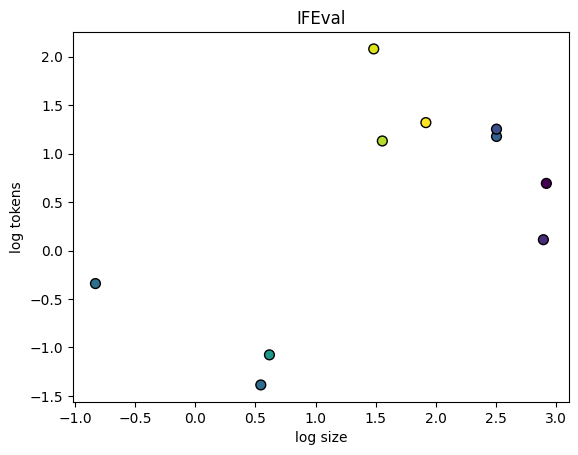

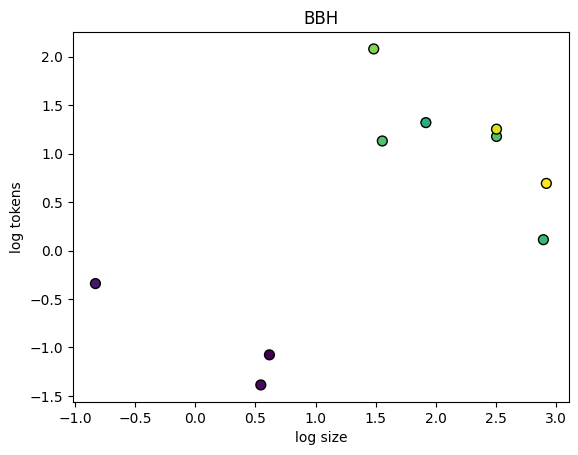

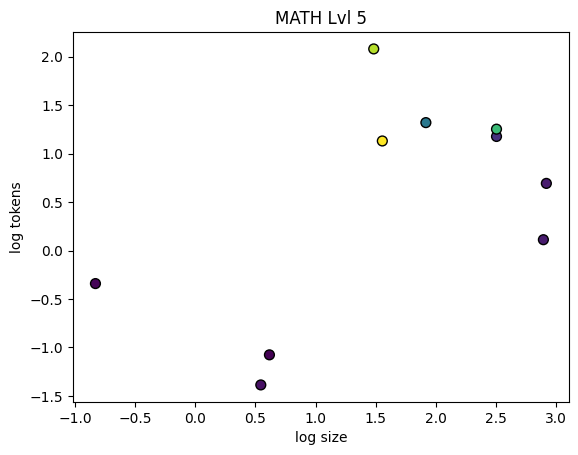

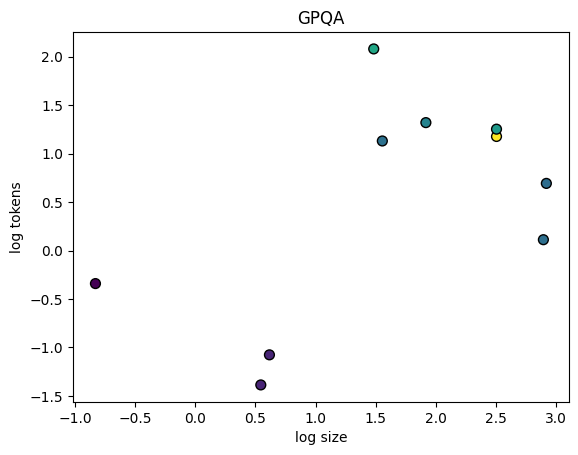

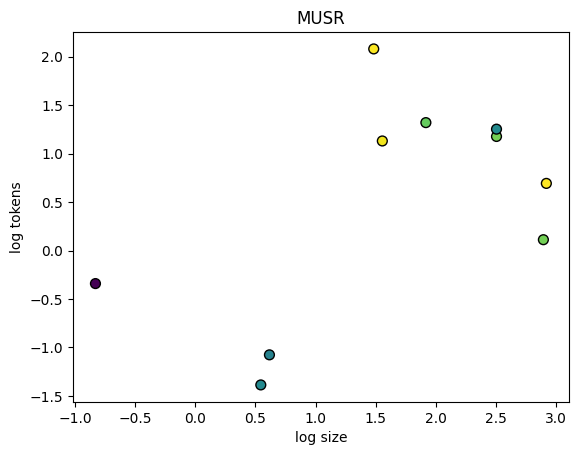

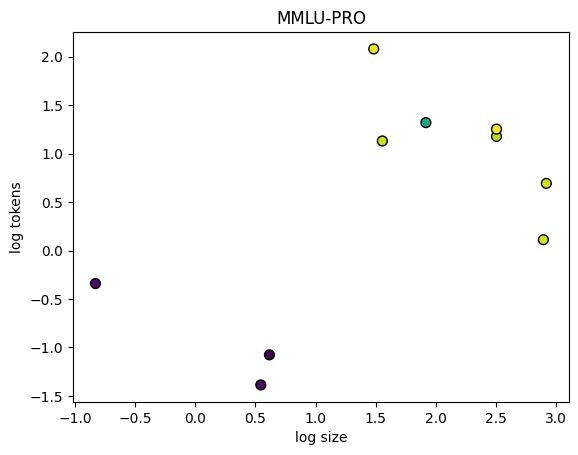

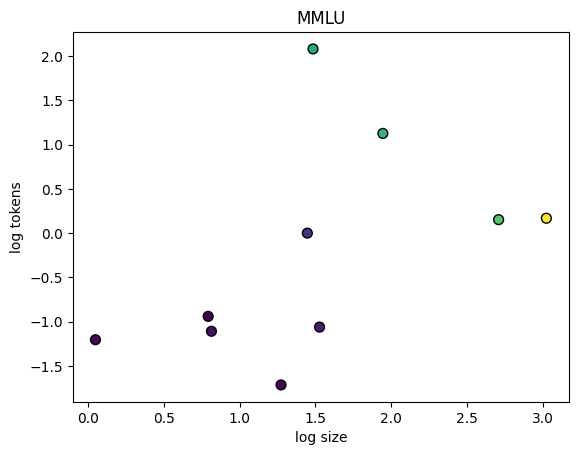

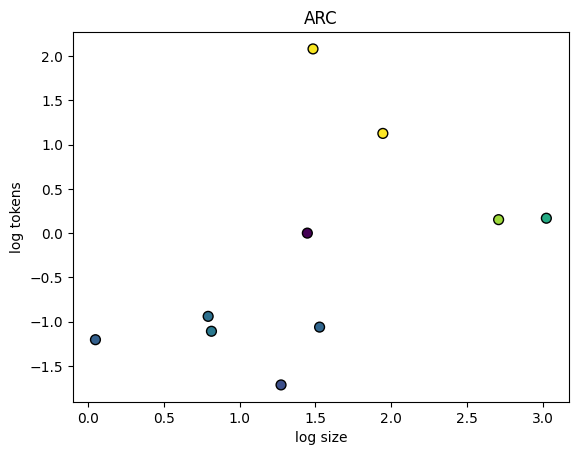

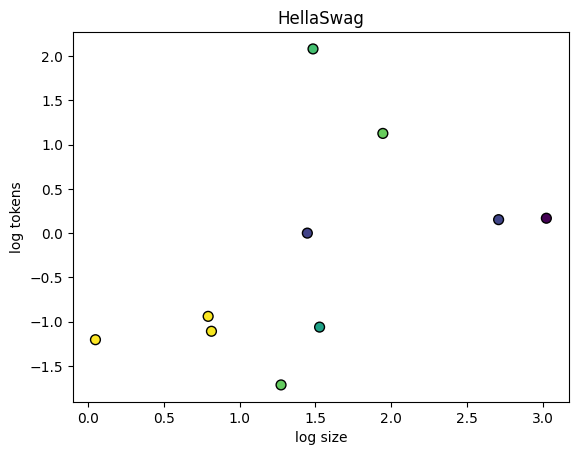

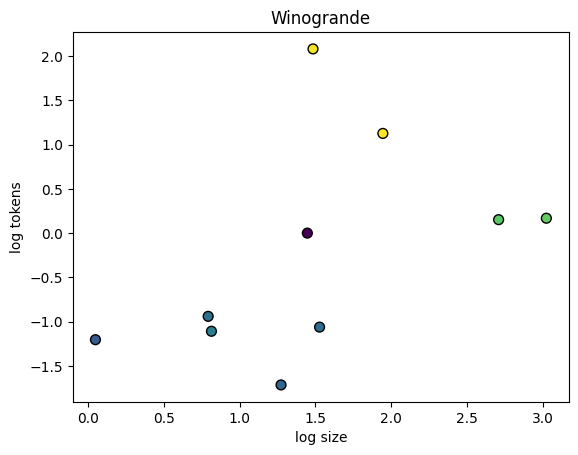

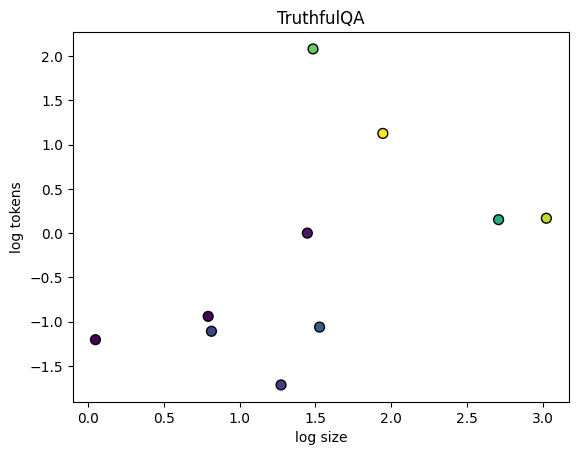

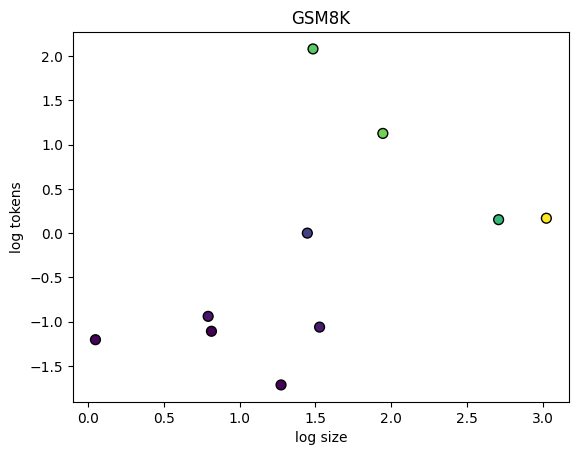

In [410]:
for scenario in scenarios:
    data = pd.read_csv('data/data_v1.csv')
    data['logS'] = np.log(data['#Params (B)'])
    data['logT'] = np.log(data['Pretraining Data Size (T)'])
    data['logF'] = np.log(data['FLOPs (1E21)'])
    data = data.loc[~data.Instruct,['Model','Family','Instruct','logS','logT','logF']+[scenario]]
    data = data.dropna()
    selected_families = list(data.Family.value_counts().iloc[start:start+num_fam].index)
    data = data.loc[[m in selected_families for m in data.Family]]
    
    y = np.array(data[scenario])
    logS = np.array(data['logS'])
    logT = np.array(data['logT'])
    logF = np.array(data['logF'])
    Fam = np.array(data.Family)
    
    out = []
    for f in np.unique(Fam):
        ind = Fam==f
        reg = LinearRegression().fit(logS[ind][:,None], y[ind])
        out.append([logS[ind].mean(),logT[ind].mean(), reg.intercept_, reg.coef_[0]])
    out = np.array(out)
    
    plt.figure()  # Add this line to create a new figure for each scenario
    plt.scatter(out[:,0], out[:,1], c=out[:,3], cmap='viridis', s=50, edgecolor='k')
    plt.xlabel('log size')
    plt.ylabel('log tokens')
    plt.title(scenario)
    plt.show()  # Use plt.show() instead of plt.plot() to display the plot
